In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.model_selection import learning_curve

from IPython.display import display, Latex

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Time to get your hands dirty! Supernova distances and redshift

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

This is a [Nobel prize](https://www.nobelprize.org/prizes/physics/2011/riess/facts/) plot by [Riess et al](https://iopscience.iop.org/article/10.1086/300499)

![Screen%20Shot%202022-05-01%20at%2010.48.48.png](attachment:Screen%20Shot%202022-05-01%20at%2010.48.48.png)

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

These are some (synthetic but realistic; see textbook) supernova data

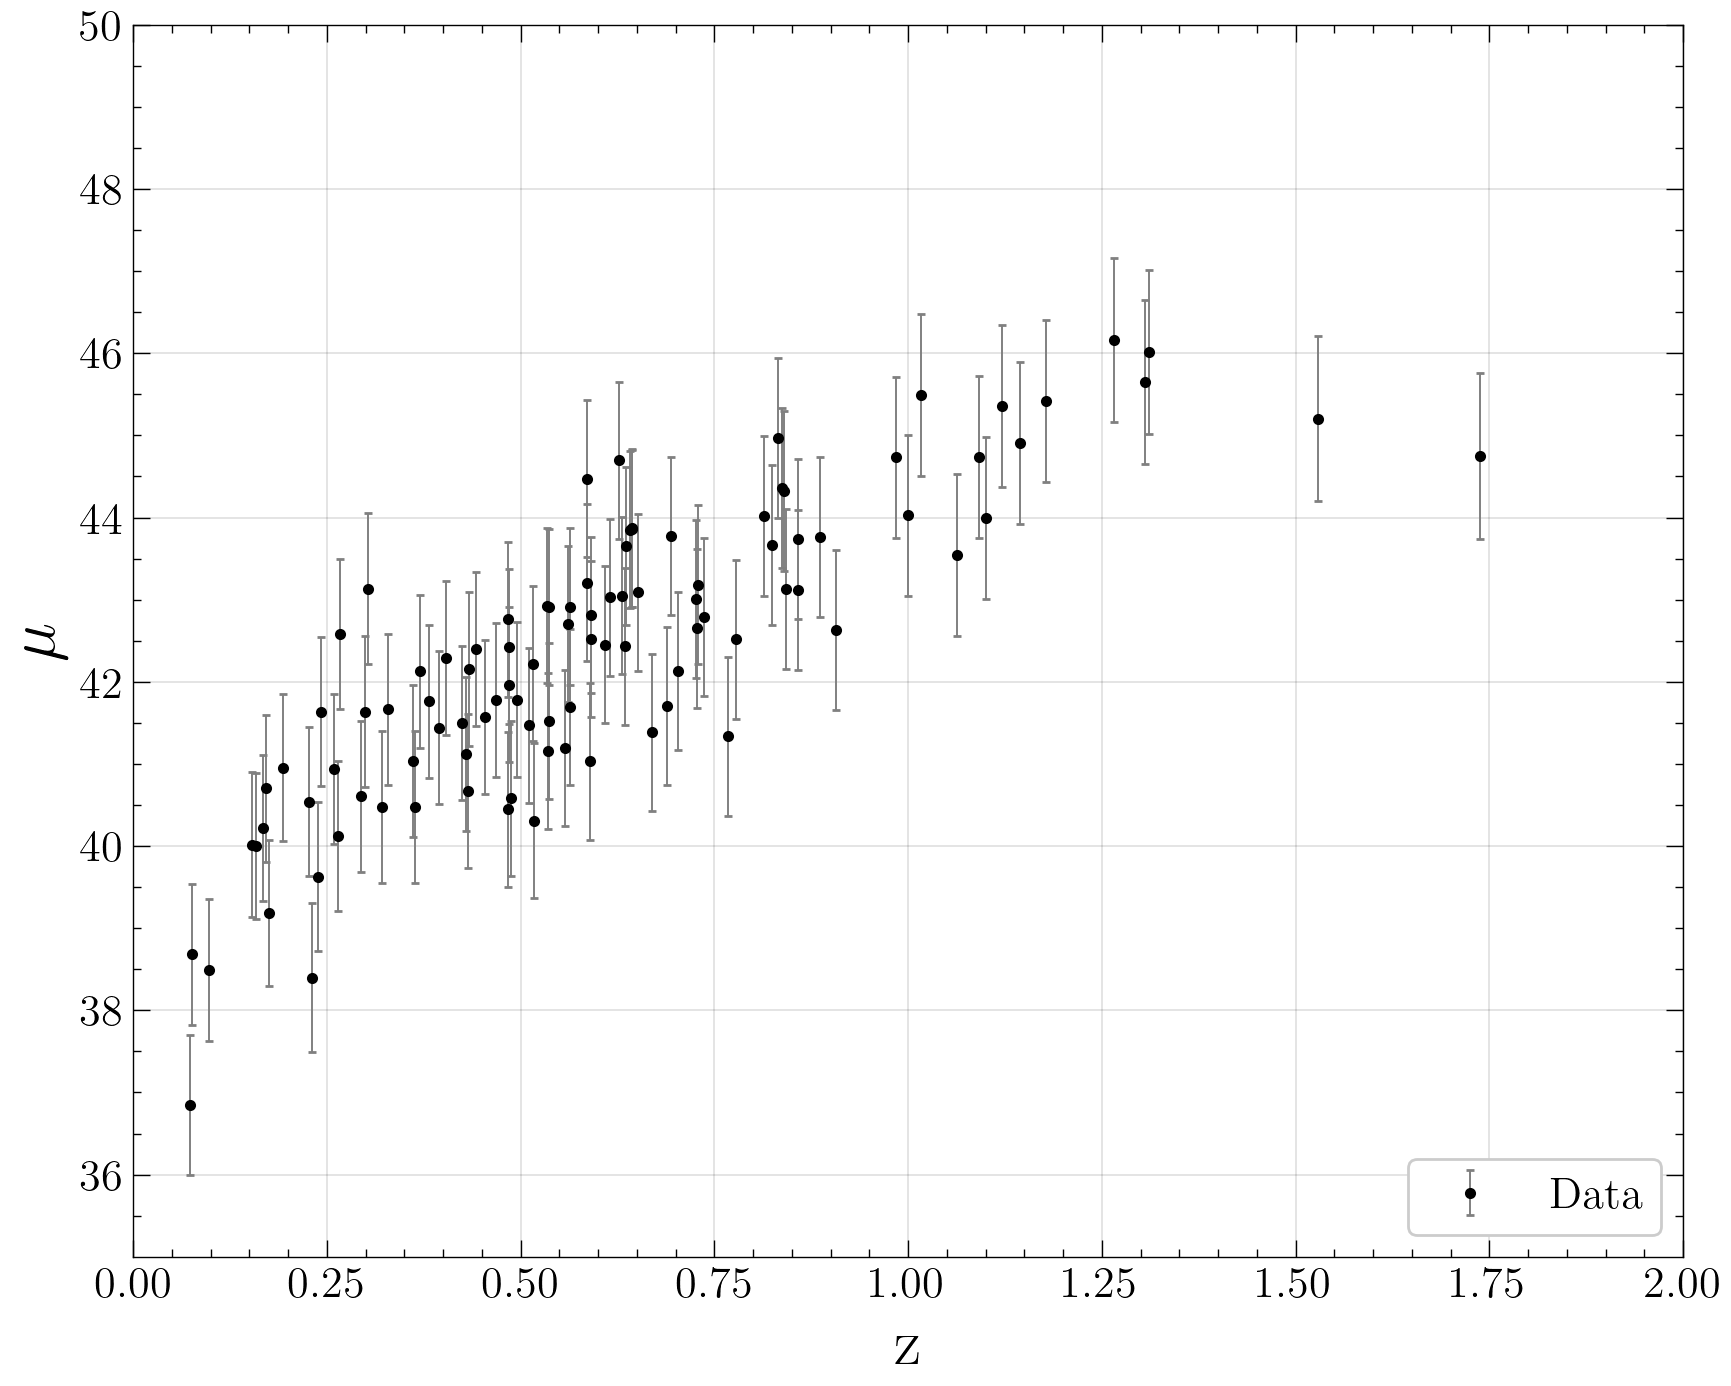

In [2]:
from astroML.datasets import generate_mu_z

N = 100
z_sample, mu_sample, dmu = generate_mu_z(N, random_state=1234)

plt.figure(figsize=(10,8))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.7, label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

# Code

## 1) Linear Regression

In [3]:
lin_reg = LinearRegression()
lin_reg.fit(z_sample[:, np.newaxis], mu_sample[:, np.newaxis], sample_weight=dmu)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)

[39.60456481] [[4.5911933]]


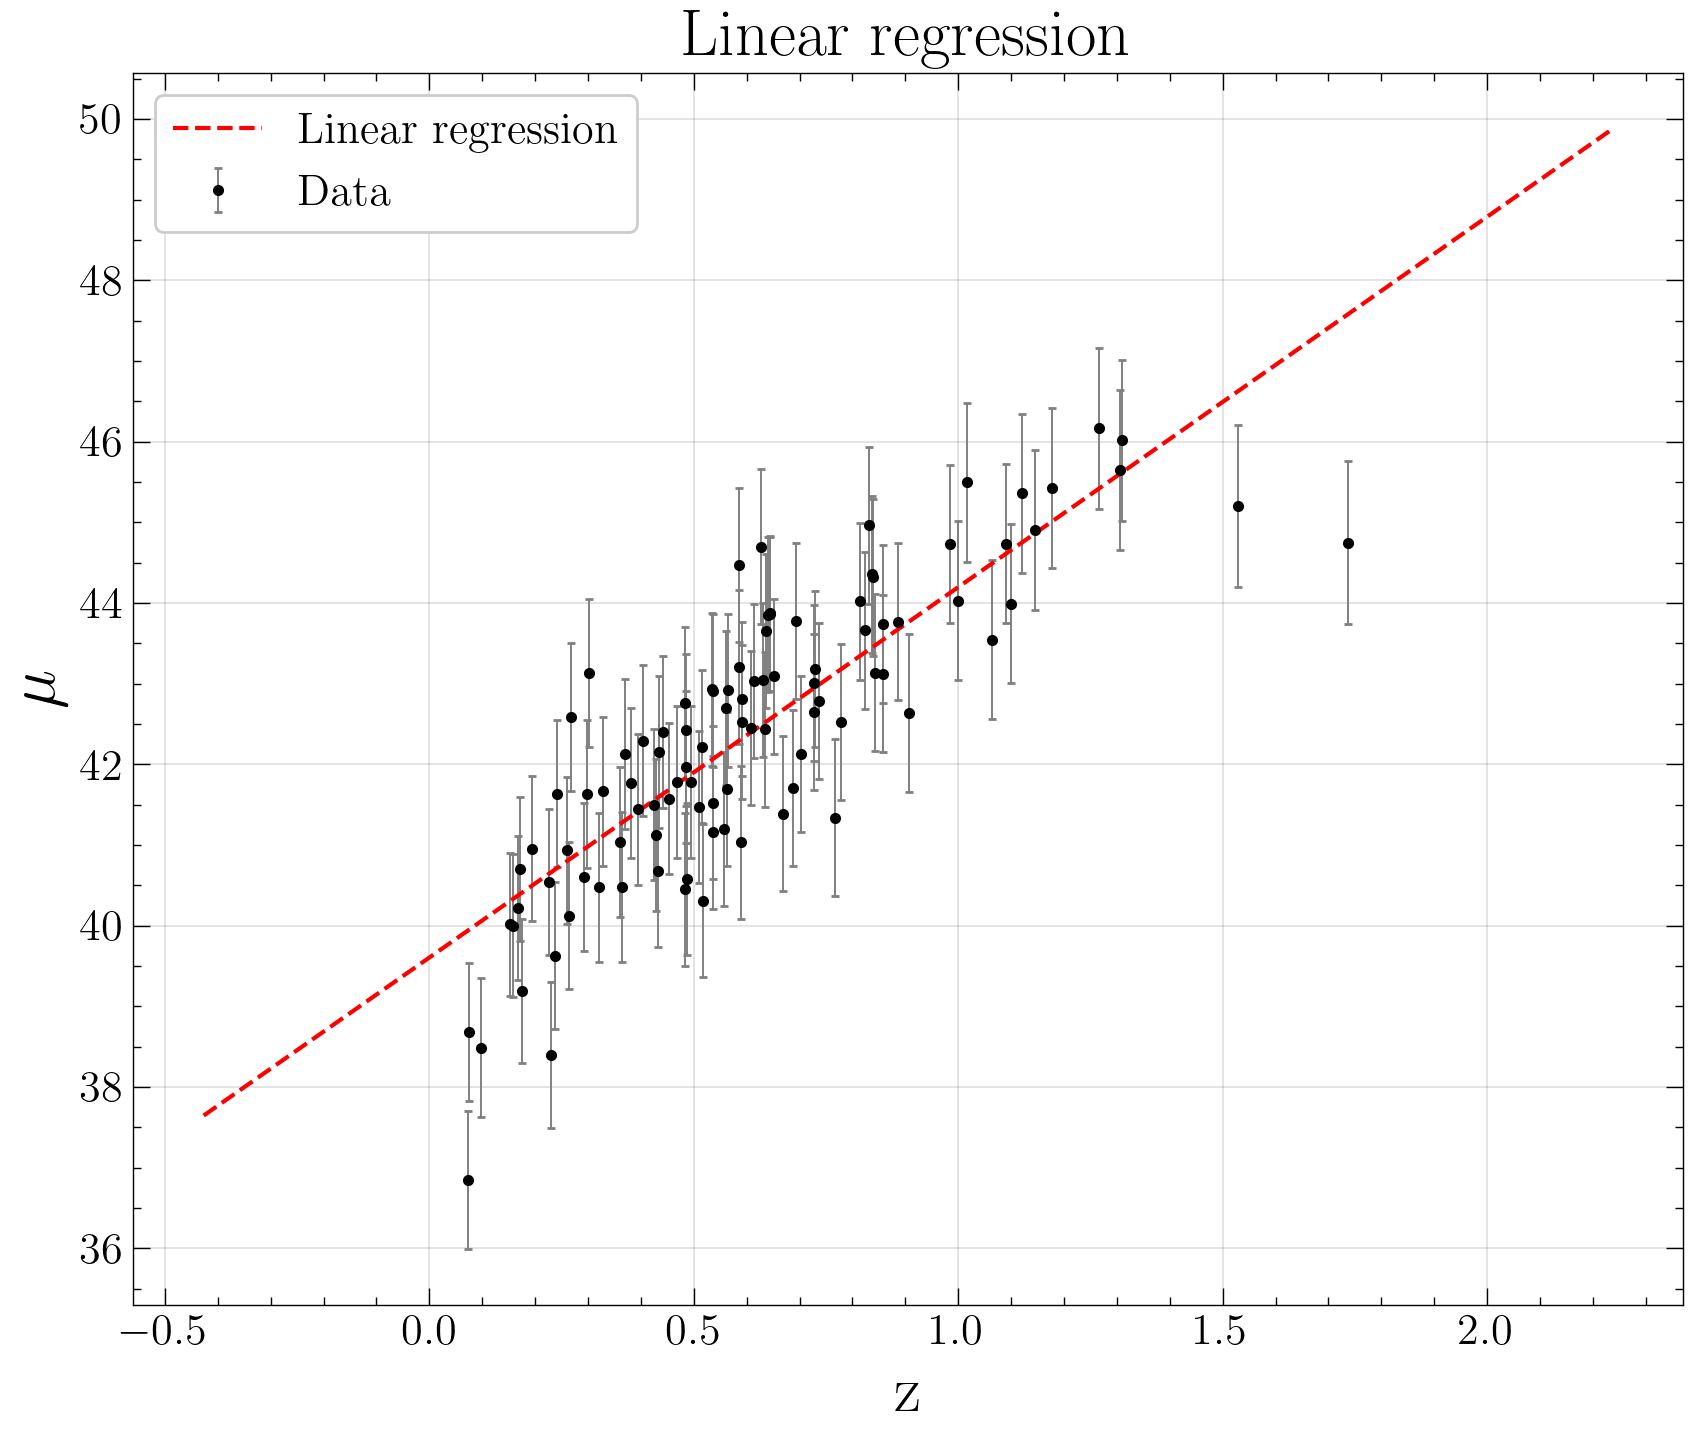

In [4]:
x_dense = np.linspace(np.min(z_sample)-0.5, np.max(z_sample)+0.5, 1000)
y_pred = lin_reg.predict(x_dense[:, np.newaxis])

plt.figure(figsize=(10,8))
plt.title('Linear regression')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.7, label='Data')
plt.plot(x_dense, y_pred, ls='--', color='red', label='Linear regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend();

## 2) Polynomial Regression

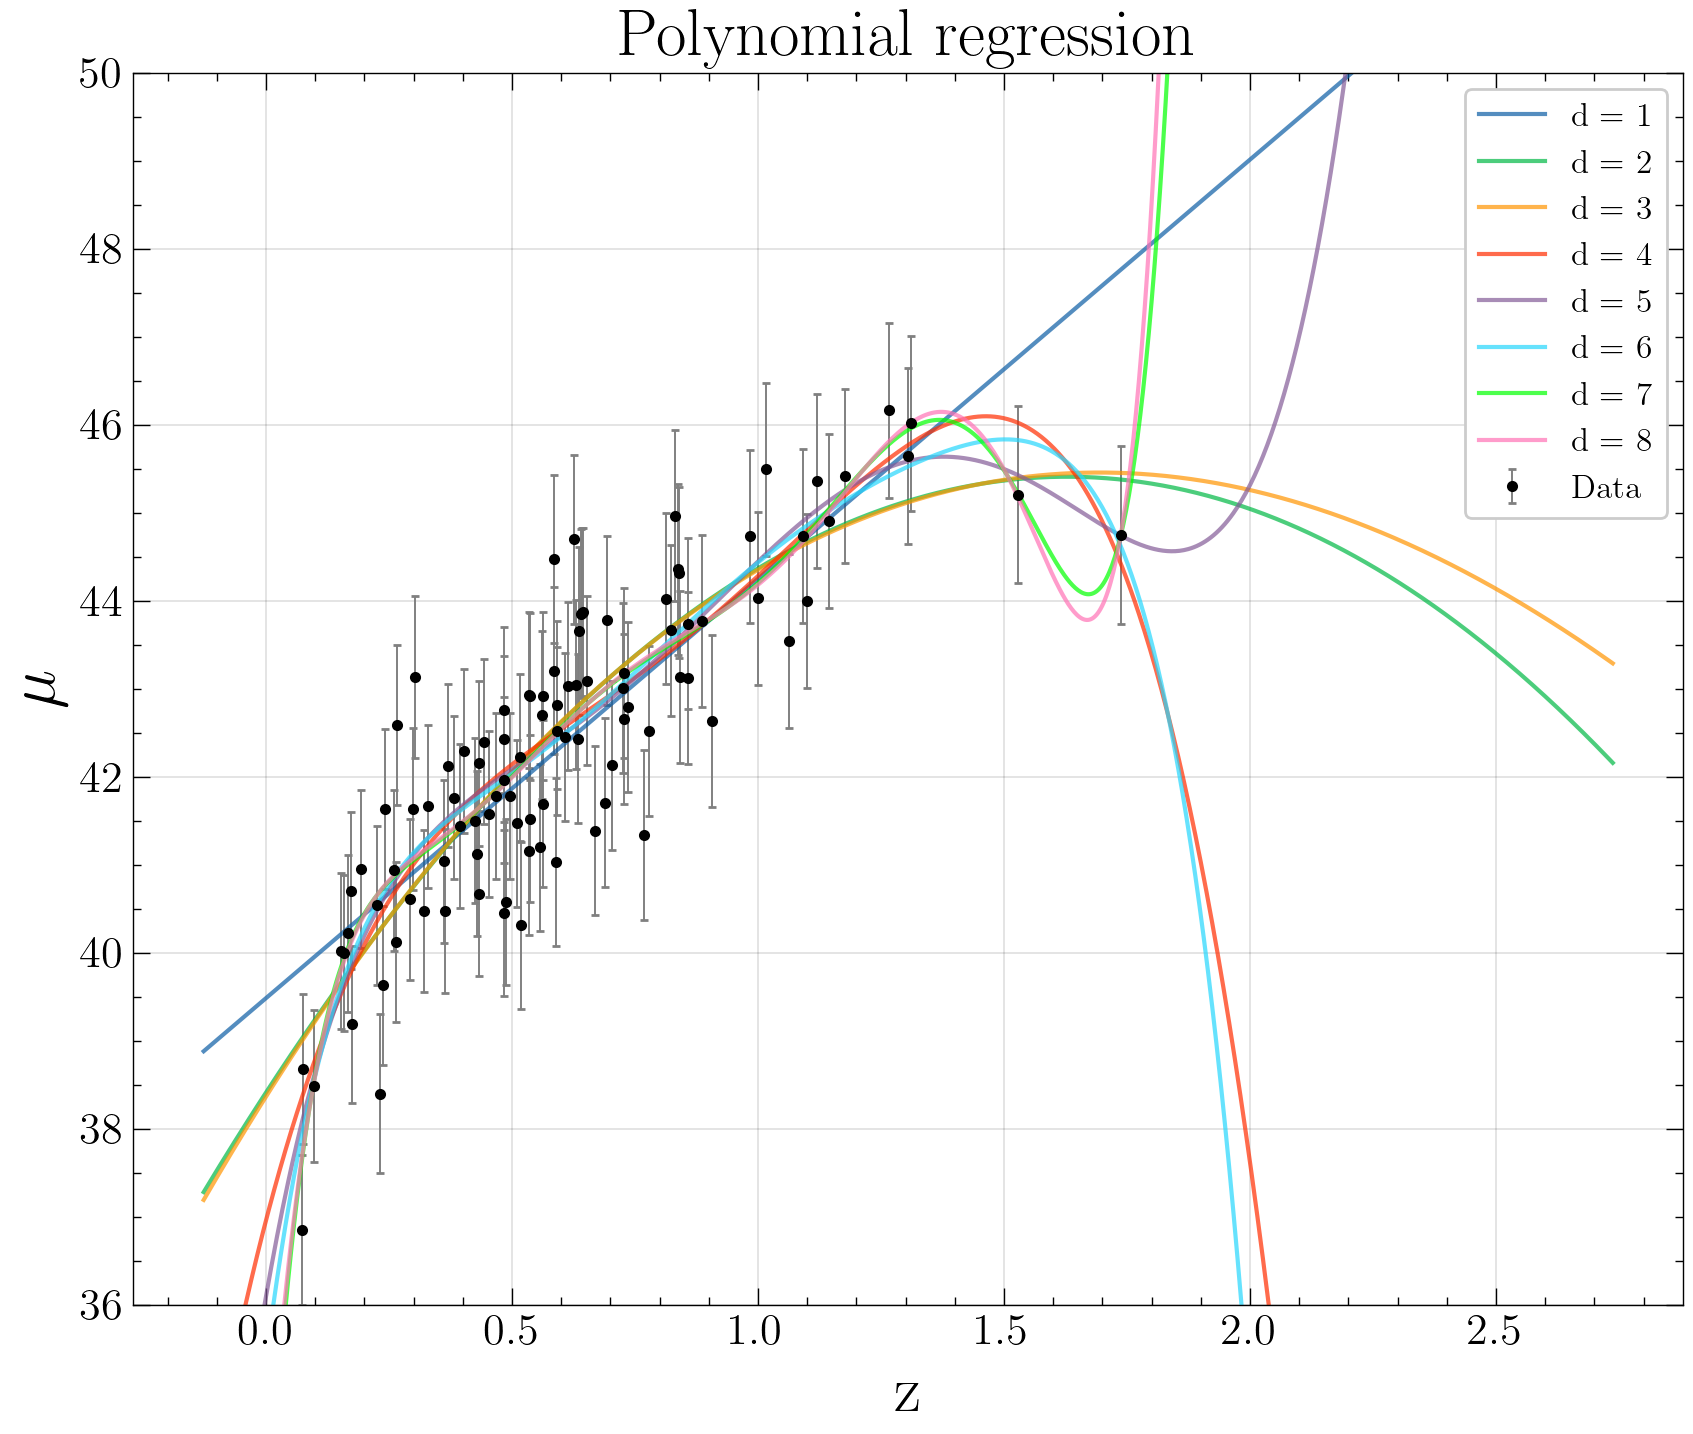

In [5]:
degree_array = np.arange(1, 9)

plt.figure(figsize=(10,8))
plt.title('Polynomial regression')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.7, label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")

x_dense = np.linspace(np.min(z_sample)-0.2, np.max(z_sample)+1, 1000)

for degree in degree_array:
    model = PolynomialRegression(degree)
    model.fit(z_sample[:, np.newaxis], mu_sample, y_error=dmu)
    #print(model.coef_)

    y_pred = model.predict(x_dense[:, np.newaxis])
    
    plt.plot(x_dense, y_pred, label=f'd = {degree}', alpha=0.7)

plt.ylim(36, 50)
plt.legend(fontsize=12);

I think that the polynomial of $degree =3$ is the best one ($degree =2$ is very similar).\
Higher-degree polynomials fit the data very well, but then for redshifts larger than those in the dataset they go very fast either to zero or infinity, which is not the behaviour I would expect.

## 3) Cross-validation

### 3.1) Checking if `GridSearchCV` works properly with a mock dataset 

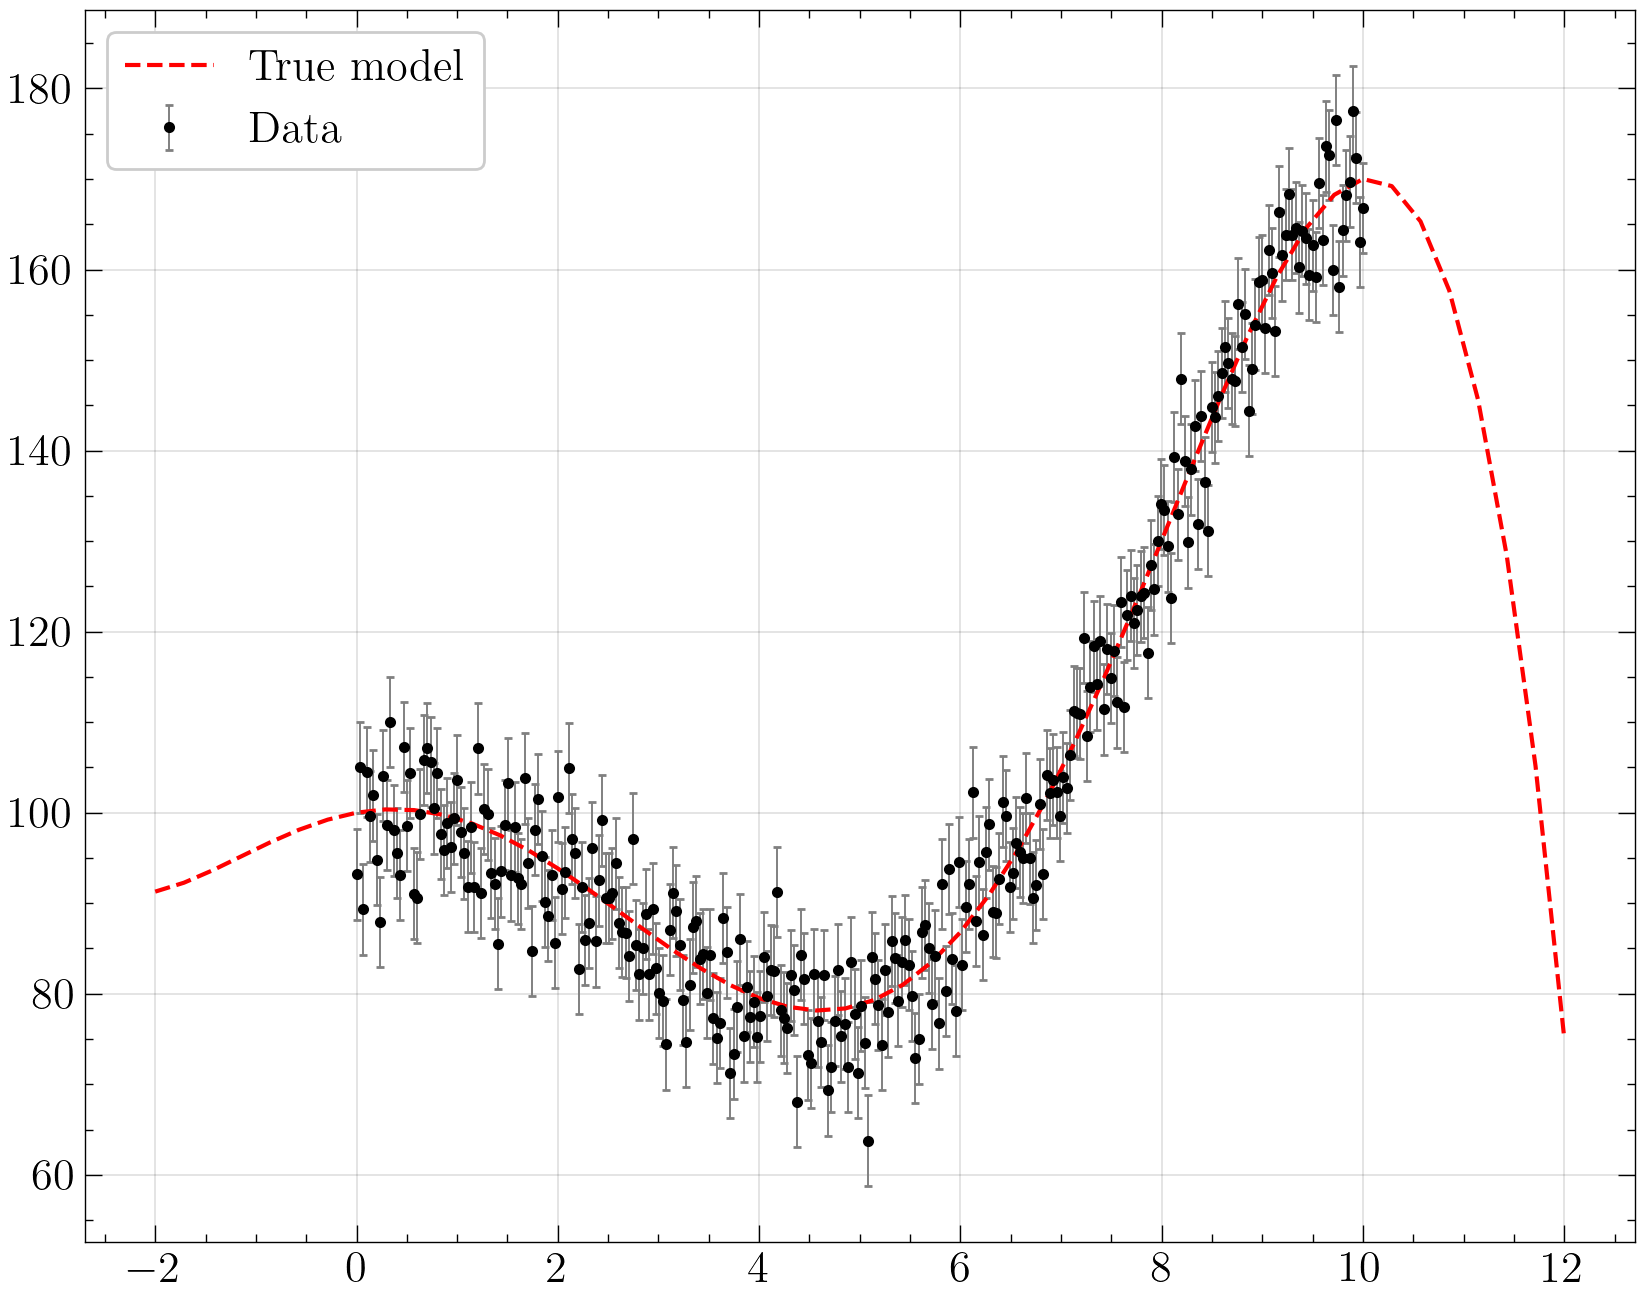

In [6]:
def mock_model(x_mock):
    return 100 + 2*x_mock - 2.5*(x_mock**2) - 0.3*(x_mock**3) + 0.16*(x_mock**4) - 0.01*(x_mock**5)

x_mock = np.linspace(0, 10, 300)
sigma_mock = 5
y_mock =  mock_model(x_mock) + np.random.normal(0., sigma_mock, len(x_mock))
y_mock_err = sigma_mock*np.ones(len(x_mock)) 

plt.figure(figsize=(10,8))
plt.errorbar(x_mock, y_mock, y_mock_err, fmt='.k', ecolor='gray', lw=0.7, label='Data')
x_dense = np.linspace(-2, 12)
plt.plot(x_dense, mock_model(x_dense), color='red', ls='--', label='True model')
plt.legend();

In [7]:
K = 10
grid = GridSearchCV(PolynomialRegression(), {'degree': degree_array}, scoring='neg_mean_squared_error', cv= K)
grid.fit(X=x_mock[:, np.newaxis], y=y_mock)
h_opt = grid.best_params_['degree']
print(h_opt)

5


Usually `GridSearchCV` returns the correct answer, i.e $degree =5$, for $K\geq5$.

### 3.2) Implementing cross-validation for our dataset

In [8]:
K = 30
grid = GridSearchCV(PolynomialRegression(), {'degree': degree_array}, scoring='neg_mean_squared_error', cv= K)
grid.fit(X=z_sample[:, np.newaxis], y=mu_sample)
h_opt = grid.best_params_['degree']
print(h_opt)

5


`GridSearchCV` does not directly accept the uncertainties on y, but in our case the errors are homoschedastic and so this is not a problem.

The answer of `GridSearchCV` ($degree =5$) is different from my guess ($degree =3$). However, I based my decision also on the behaviour of the model outside of the dataset domain.

### 3.3) Cross-validation error

Piece of code copied from the lecture

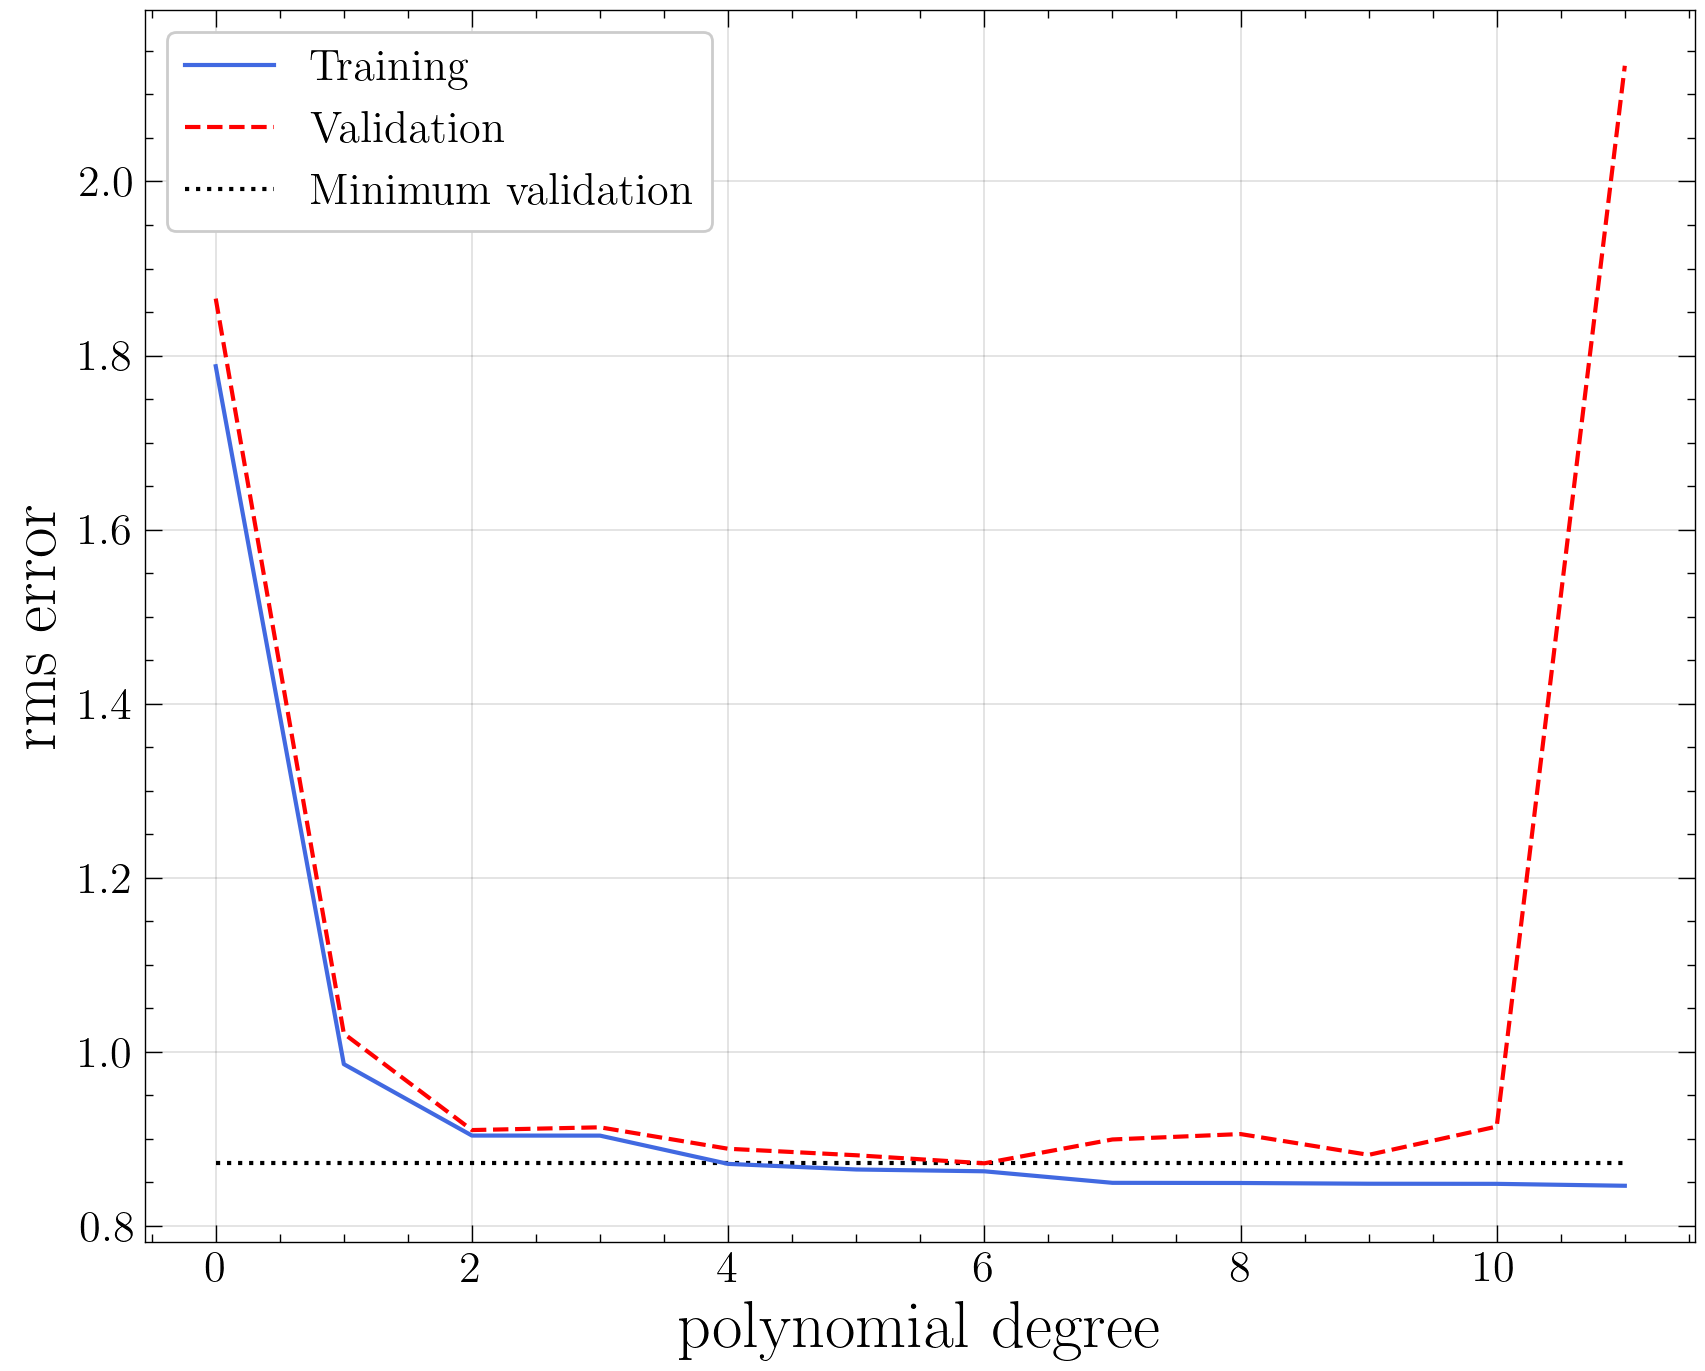

In [9]:
x_cv, y_cv, y_cv_err = generate_mu_z(N, random_state=1)

#------------------------------------------------------------
# Third figure: plot errors as a function of polynomial degree d
d = np.arange(0, 12)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

fig = plt.figure(figsize=(10, 8))
for i in range(len(d)):
    model = PolynomialRegression(d[i])
    model.fit(z_sample[:, np.newaxis], mu_sample)
    p = np.flip(model.coef_)
    training_err[i] = np.sqrt(np.sum((np.polyval(p, z_sample) - mu_sample)**2) / len(mu_sample))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, x_cv) - y_cv)**2) / len(y_cv))

plt.plot(d, training_err, color='royalblue', label='Training')
plt.plot(d, crossval_err, ls='--', color='red', label='Validation')
plt.plot(d, np.min(crossval_err)*np.ones(len(d)), ':k', zorder=0, label='Minimum validation')
plt.xlabel('polynomial degree')
plt.ylabel('rms error')
plt.legend(loc=2)

plt.show()

We can see that in the interval $degree \in[4,6]$ the models are very similar to one another.\
For $degree <4$ we have underfitting, while for $degree >6$ we start to experience overfitting, which drastically increases for $degree >10$.

## 4) Basis-function regression

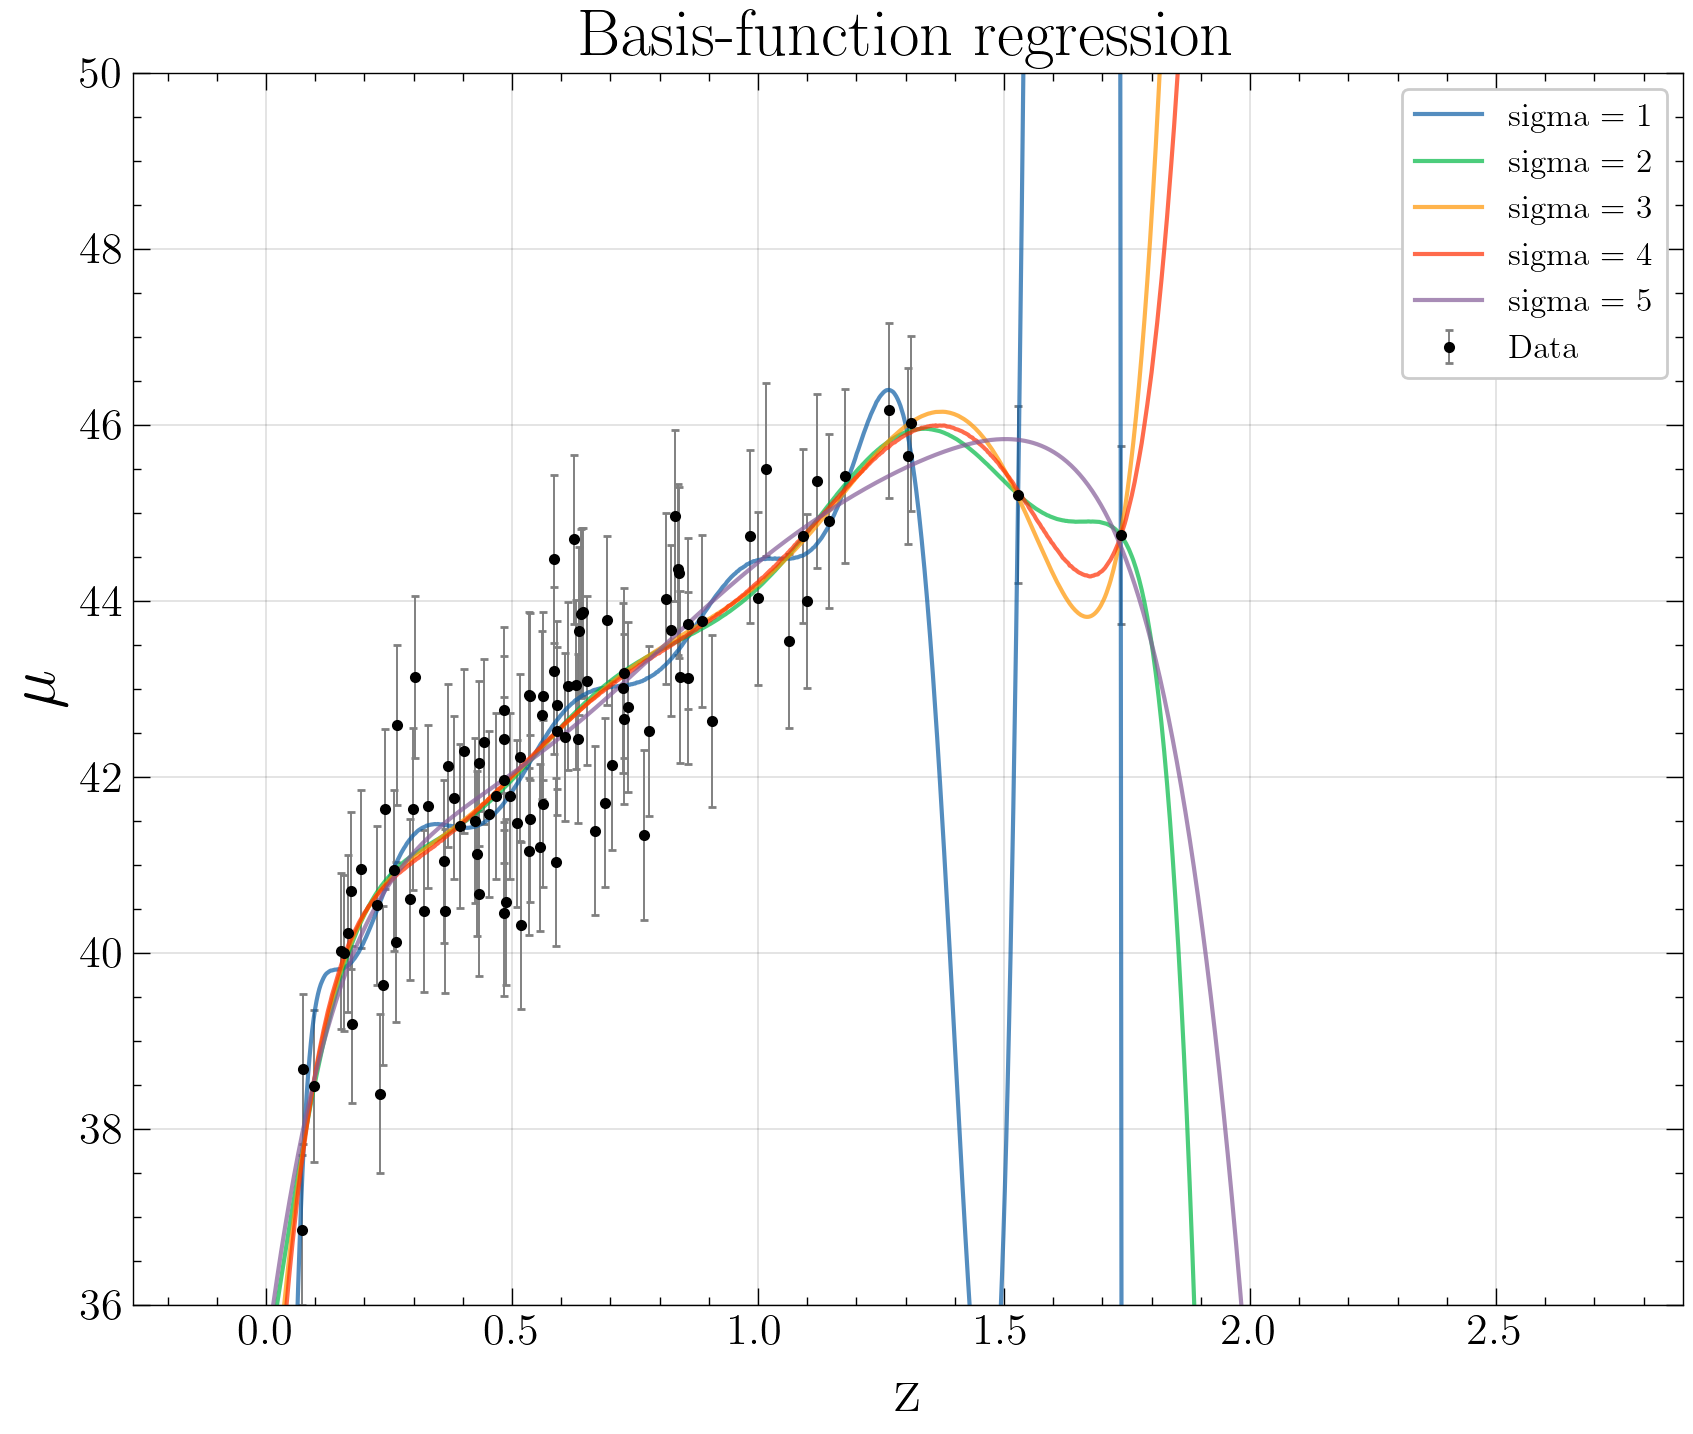

In [10]:
sigma_array = np.arange(1, 6)

plt.figure(figsize=(10,8))
plt.title('Basis-function regression')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.7, label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")

x_dense = np.linspace(np.min(z_sample)-0.2, np.max(z_sample)+1, 1000)

for sigma in sigma_array:
    model = BasisFunctionRegression('gaussian', mu=x_dense[:, np.newaxis], sigma=sigma)
    model.fit(z_sample[:, np.newaxis], mu_sample, y_error=dmu)
    #print(model.coef_)

    y_pred = model.predict(x_dense[:, np.newaxis])
    
    plt.plot(x_dense, y_pred, label=f'sigma = {sigma}', alpha=0.7)

plt.ylim(36, 50)
plt.legend(fontsize=12);

I tried to implement K-fold cross-validation, but:\
<font color='red'>Invalid parameter 'sigma' for estimator BasisFunctionRegression(). Valid parameters are: ['basis_func', 'fit_intercept', 'kwds', 'regularization'].</font>

## 5) Kernel regression

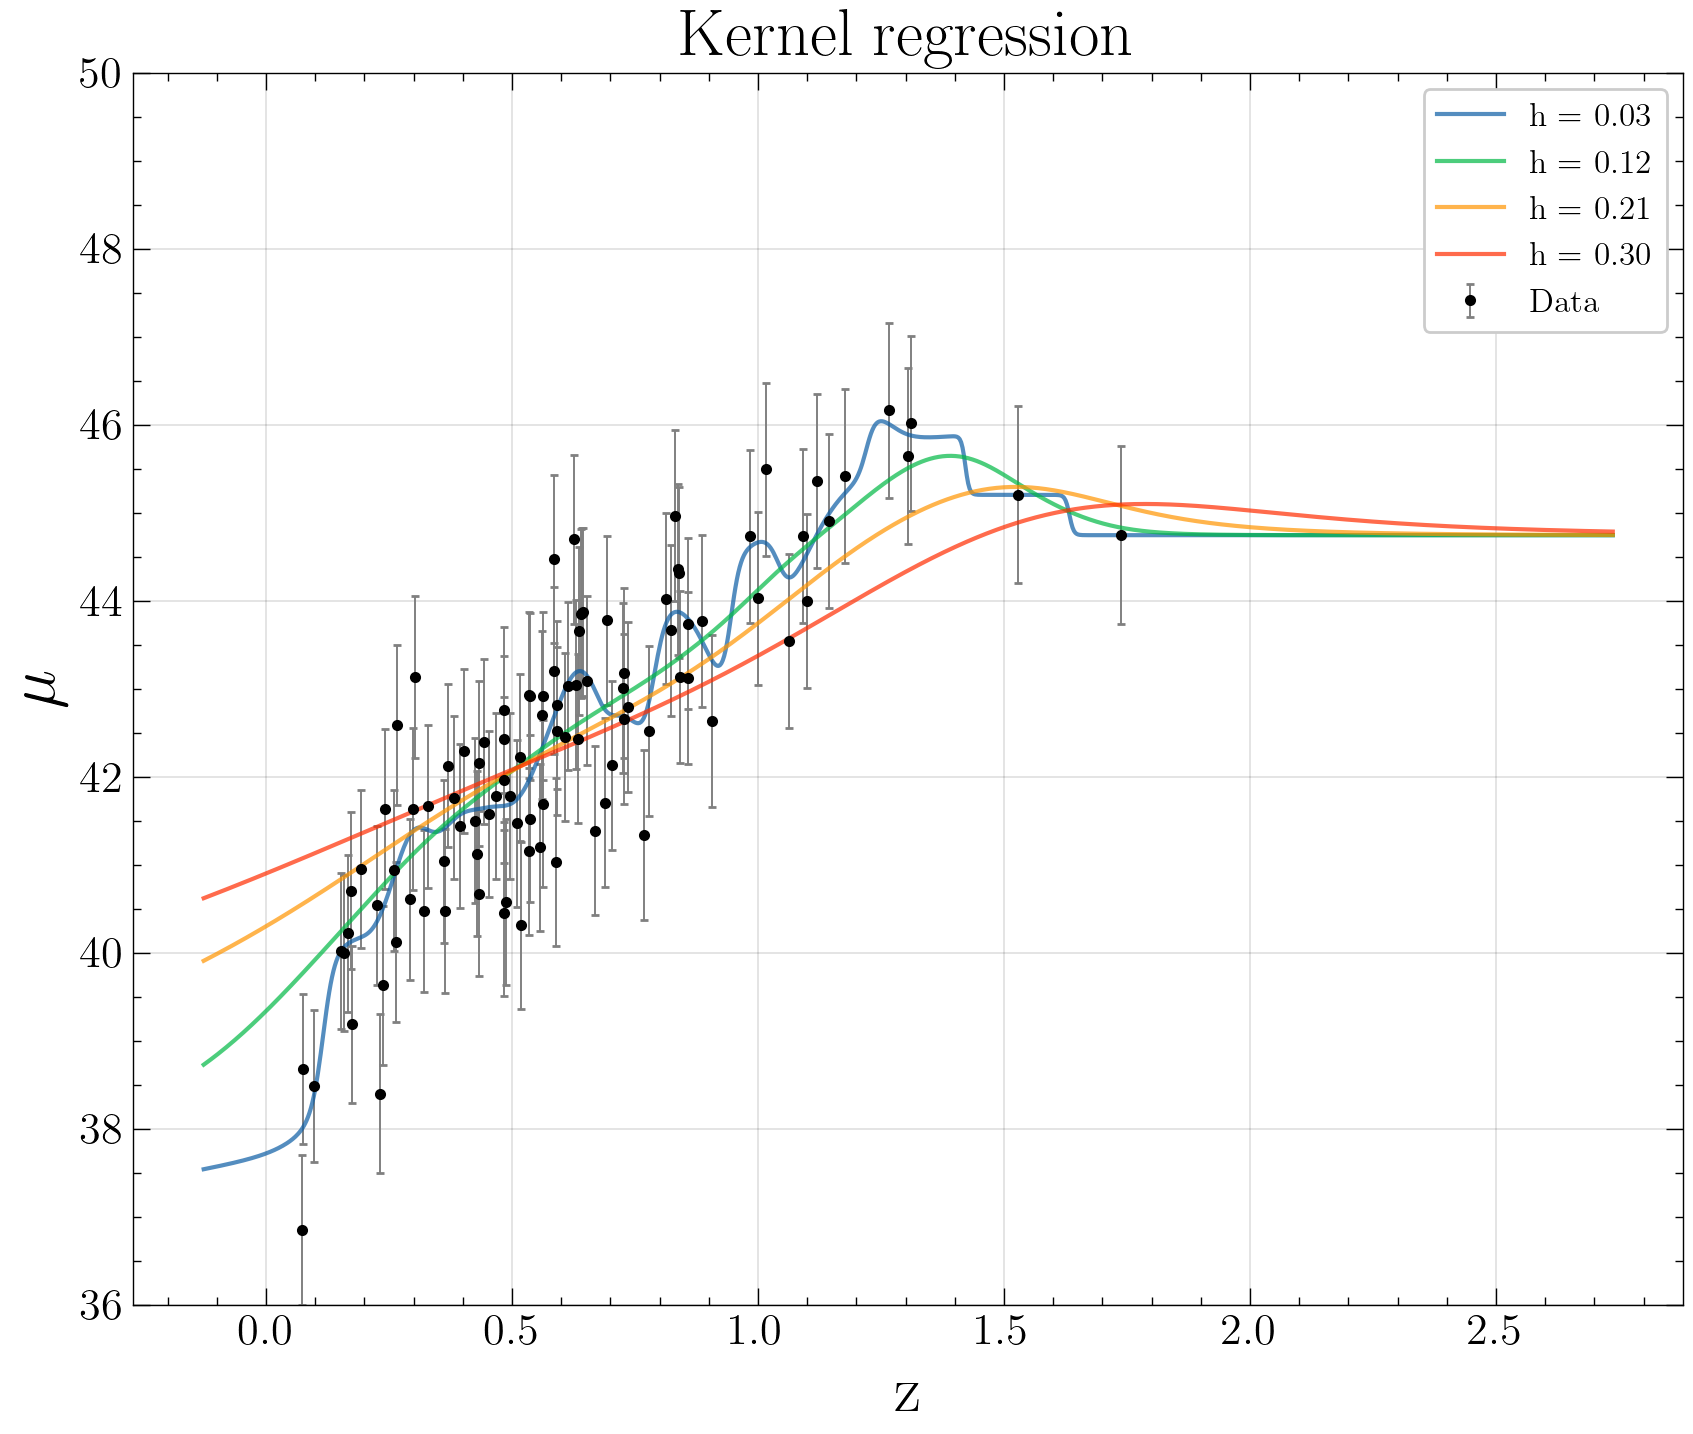

In [11]:
h_array = np.linspace(0.03, 0.3, 4)

plt.figure(figsize=(10,8))
plt.title('Kernel regression')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=0.7, label='Data')
plt.xlabel("z")
plt.ylabel("$\mu$")

x_dense = np.linspace(np.min(z_sample)-0.2, np.max(z_sample)+1, 1000)

for h in h_array:
    model = NadarayaWatson(kernel='gaussian', h=h)
    model.fit(z_sample[:, np.newaxis], mu_sample)
    #print(model.coef_)

    y_pred = model.predict(x_dense[:, np.newaxis])
    
    plt.plot(x_dense, y_pred, label=f'h = {h:.2f}', alpha=0.7)

plt.ylim(36, 50)
plt.legend(fontsize=12);

In [12]:
h_array = np.linspace(0.03, 2, 100)
K = 10
grid = GridSearchCV(NadarayaWatson(kernel='gaussian'), {'h': h_array}, scoring='neg_mean_squared_error', cv= K)
grid.fit(X=x_mock[:, np.newaxis], y=y_mock)
h_opt = grid.best_params_['h']
print(h_opt)

0.1095959595959596


## 6) Learning curve in the case of polynomial regression

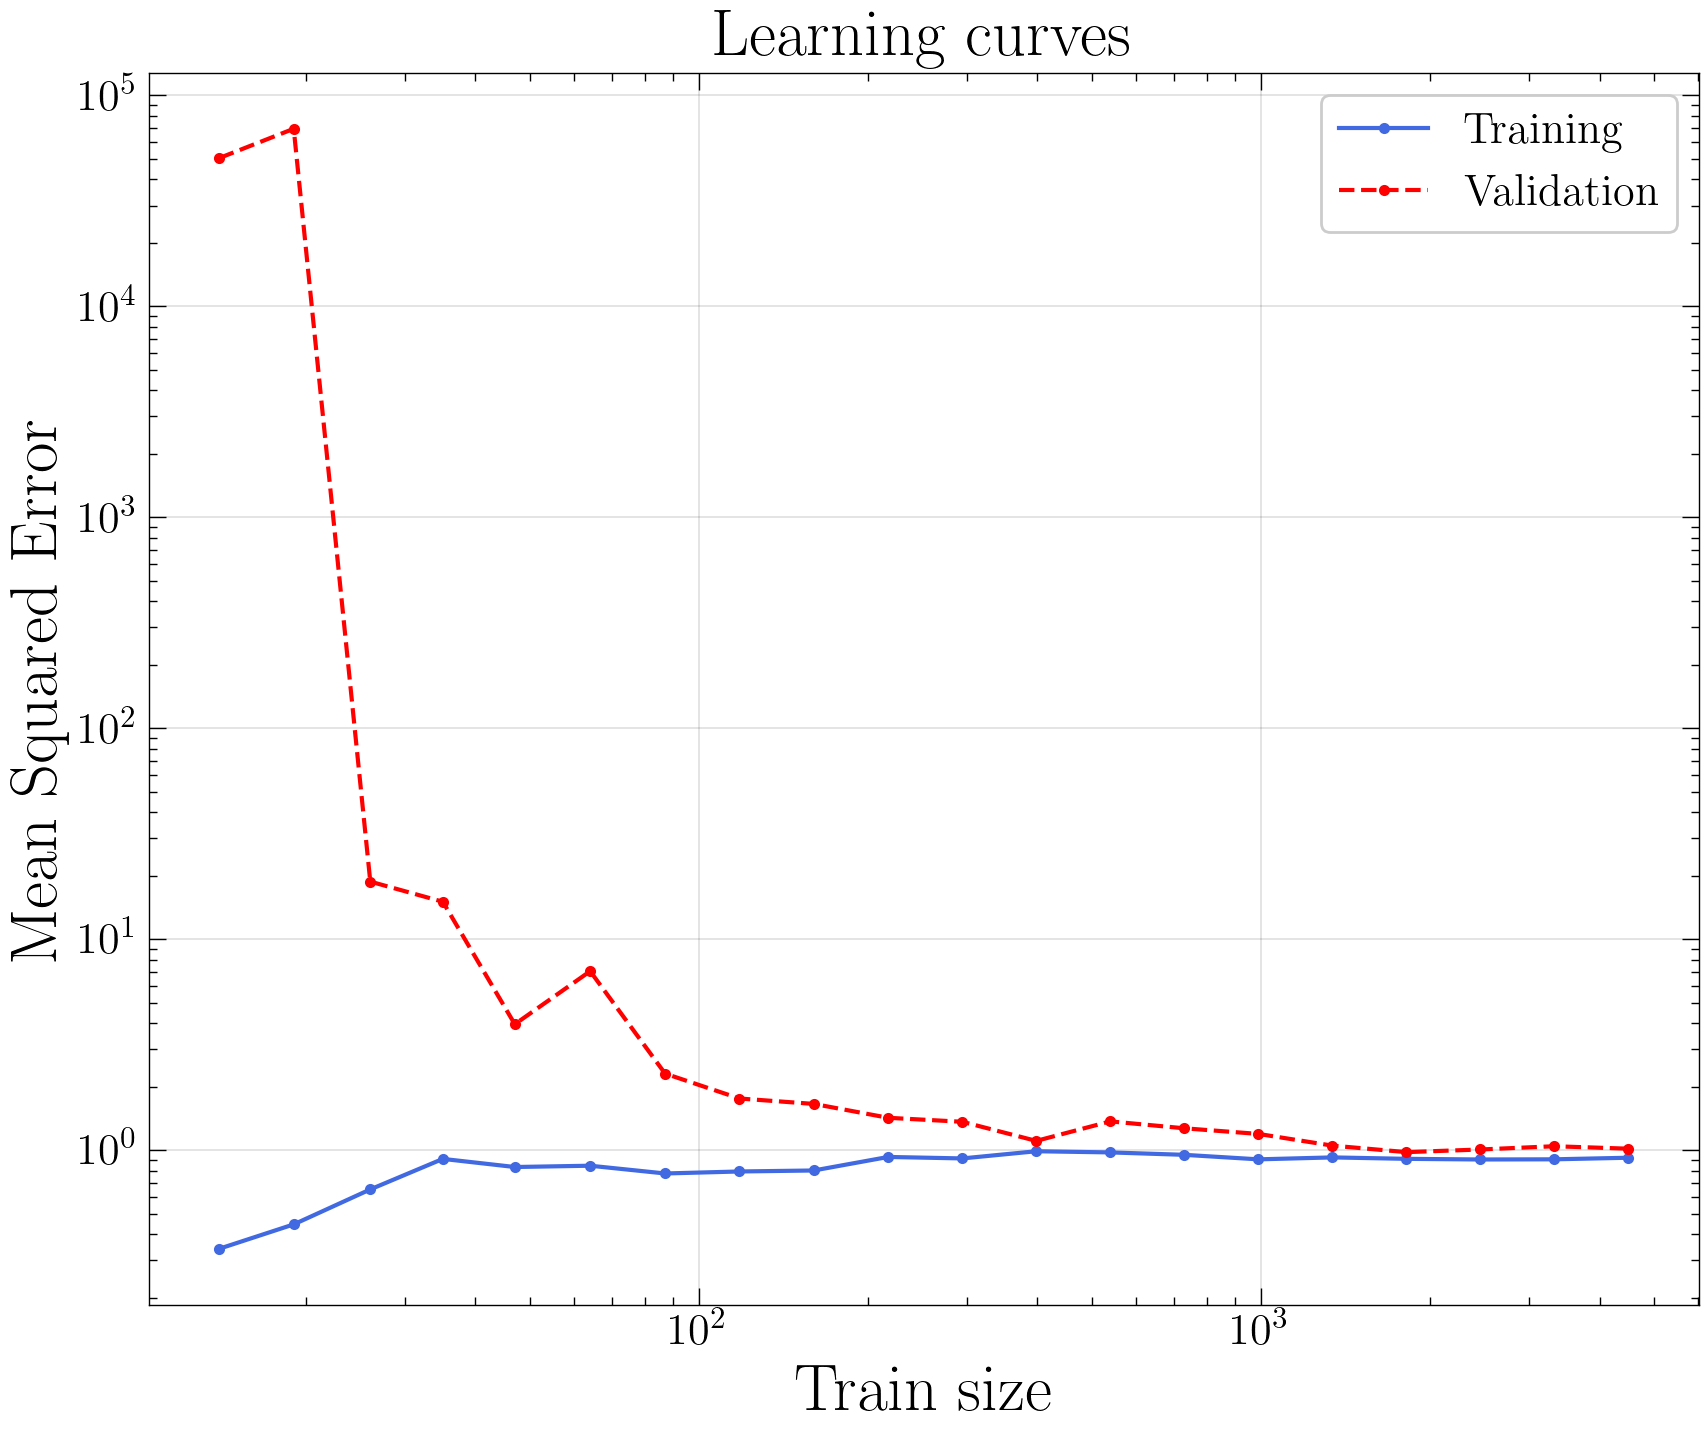

In [13]:
x_lc, y_lc, y_lc_err = generate_mu_z(5000, random_state=1)

K = 10
model = PolynomialRegression(degree=5)
train_sizes, train_scores_linreg, test_scores_linreg = \
    learning_curve(model, x_lc[:, np.newaxis], y_lc, train_sizes=np.logspace(-2.5, 0, 20), \
    scoring='neg_mean_squared_error', cv=K)
    
plt.plot(train_sizes, -train_scores_linreg.mean(1), '.-', color='royalblue', label='Training')
plt.plot(train_sizes, -test_scores_linreg.mean(1), '.--', color='red', label='Validation')
 
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Train size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curves')
plt.legend();